# 1. Data Preperation
### data set
$$X_{train} \in R^{50000 \times 784}, ~ y_{train} \in R^{50000}$$
$$X_{val} \in R^{10000 \times 784}, ~ y_{val} \in R^{10000}$$
$$X_{test} \in R^{10000 \times 784}, ~ y_{test} \in R^{10000}$$

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn


batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

50000 10000 10000


### Plotting Dataset

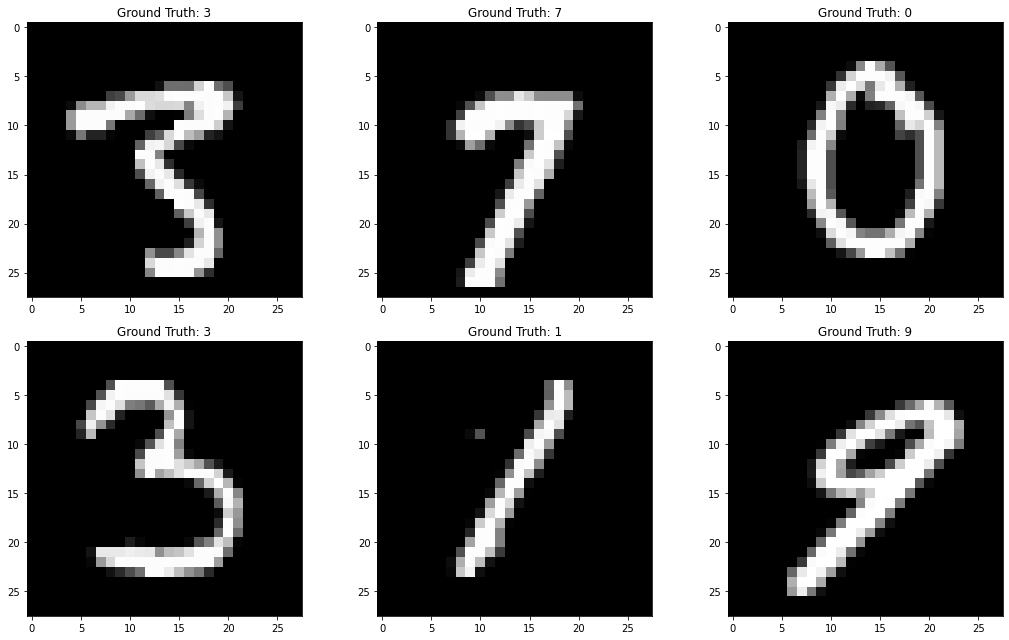

In [2]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

# 2. Model Architecture

In [3]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
        
    def forward(self, x):
        x = self.linear(x)
        return x

# 3. Define Cost Function (Loss Function)

In [4]:
cls_loss = nn.CrossEntropyLoss()

# 4. Train & Evaluation
1. 1 Epoch 당 시간 차이 확인해보기

- Using CPU: i5-1135G7

In [5]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import time

# ======= Construct Model ======= #
model = LinearModel()
print('total parameters: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ======= Construct Optimizer ======= #
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

li_epoch = []
li_train_loss = []
li_val_loss = []
li_acc = []
li_acc_epoch = []

epoch = 10

for i in range(1, epoch+1):
    start = time.time()    ### 시간 측정 
    
    # ===== Train ===== #
    train_loss = 0
    model.train()
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad()
        
        input_X = input_X.squeeze()  # squeeze(): 차원이 1인 axis 제거
        input_X = input_X.view(-1, 28*28)
        pred_y = model(input_X)
        
        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    li_train_loss.append(train_loss)   # 1 epoch에 대한 train loss
    li_epoch.append(i)
    
    # ===== Validation ===== #
    val_loss = 0
    model.eval()
    
    with torch.no_grad(): # Val 과정에서 그라디언트가 사용되지 않도록 함
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 28*28)
            pred_y = model(input_X)
            
            loss = cls_loss(pred_y.squeeze(), true_y)
            
            val_loss += loss.item()
        val_loss = val_loss / len(val_loader)   # 1 epoch에 대한 validation loss
        li_val_loss.append(val_loss)
        
    # ===== Evaludation ===== #
    correct = 0
    model.eval()
    
    with torch.no_grad():
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 28*28)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()
            
        acc = correct / len(test_loader.dataset)
        li_acc.append(acc.item())
        li_acc_epoch.append(i)
        
        end = time.time()    ### 시간 측정 
    
    print('Epoch: {} - 소요 시간: {:3.1f}초'.format(i, end-start))
        
    print('Train Loss: {:.3f}, Val Loss: {:.3f}, Test Acc: {:.3f}%'.format(train_loss, val_loss, acc*100))
        
            

total parameters: 7850
Epoch: 1 - 소요 시간: 10.6초
Train Loss: 0.741, Val Loss: 0.493, Test Acc: 88.080%
Epoch: 2 - 소요 시간: 9.3초
Train Loss: 0.438, Val Loss: 0.418, Test Acc: 89.440%
Epoch: 3 - 소요 시간: 9.1초
Train Loss: 0.389, Val Loss: 0.387, Test Acc: 90.130%
Epoch: 4 - 소요 시간: 9.2초
Train Loss: 0.364, Val Loss: 0.369, Test Acc: 90.390%
Epoch: 5 - 소요 시간: 9.2초
Train Loss: 0.349, Val Loss: 0.357, Test Acc: 90.840%
Epoch: 6 - 소요 시간: 9.7초
Train Loss: 0.338, Val Loss: 0.349, Test Acc: 90.930%
Epoch: 7 - 소요 시간: 10.0초
Train Loss: 0.330, Val Loss: 0.342, Test Acc: 91.210%
Epoch: 8 - 소요 시간: 10.3초
Train Loss: 0.323, Val Loss: 0.337, Test Acc: 91.240%
Epoch: 9 - 소요 시간: 9.7초
Train Loss: 0.318, Val Loss: 0.333, Test Acc: 91.350%
Epoch: 10 - 소요 시간: 9.8초
Train Loss: 0.313, Val Loss: 0.329, Test Acc: 91.580%


- Using GPU: MX450

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
# ======= Construct Model ======= #
model = LinearModel().to(device)
print('total parameters: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ======= Construct Optimizer ======= #
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

li_epoch = []
li_train_loss = []
li_val_loss = []
li_acc = []
li_acc_epoch = []

epoch = 10

for i in range(1, epoch+1):
    start = time.time()    ### 시간 측정 
    
    # ===== Train ===== #
    train_loss = 0
    model.train()
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad()
        
        input_X = input_X.squeeze()  # squeeze(): 차원이 1인 axis 제거
        input_X = input_X.view(-1, 28*28)
        
        input_X = input_X.to(device)
        true_y = true_y.to(device)
        pred_y = model(input_X)
        
        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    li_train_loss.append(train_loss)   # 1 epoch에 대한 train loss
    li_epoch.append(i)
    
    # ===== Validation ===== #
    val_loss = 0
    model.eval()
    
    with torch.no_grad(): # Val 과정에서 그라디언트가 사용되지 않도록 함
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 28*28)
            
            input_X = input_X.to(device)
            true_y = true_y.to(device)
            pred_y = model(input_X)
            
            loss = cls_loss(pred_y.squeeze(), true_y)
            
            val_loss += loss.item()
        val_loss = val_loss / len(val_loader)   # 1 epoch에 대한 validation loss
        li_val_loss.append(val_loss)
        
    # ===== Evaludation ===== #
    correct = 0
    model.eval()
    
    with torch.no_grad():
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 28*28)
            
            input_X = input_X.to(device)
            true_y = true_y.to(device)
            
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()
            
        acc = correct / len(test_loader.dataset)
        li_acc.append(acc.item())
        li_acc_epoch.append(i)
        
        end = time.time()    ### 시간 측정 
    
    print('Epoch: {} - 소요 시간: {:3.1f}초'.format(i, end-start))
        
    print('Train Loss: {:.3f}, Val Loss: {:.3f}, Test Acc: {:.3f}%'.format(train_loss, val_loss, acc*100))

total parameters: 7850
Epoch: 1 - 소요 시간: 10.6초
Train Loss: 0.751, Val Loss: 0.494, Test Acc: 88.190%
Epoch: 2 - 소요 시간: 10.0초
Train Loss: 0.438, Val Loss: 0.418, Test Acc: 89.540%
Epoch: 3 - 소요 시간: 9.5초
Train Loss: 0.389, Val Loss: 0.387, Test Acc: 90.110%
Epoch: 4 - 소요 시간: 10.0초
Train Loss: 0.365, Val Loss: 0.369, Test Acc: 90.650%
Epoch: 5 - 소요 시간: 9.6초
Train Loss: 0.349, Val Loss: 0.358, Test Acc: 90.800%
Epoch: 6 - 소요 시간: 9.4초
Train Loss: 0.338, Val Loss: 0.349, Test Acc: 90.920%
Epoch: 7 - 소요 시간: 9.3초
Train Loss: 0.330, Val Loss: 0.342, Test Acc: 91.030%
Epoch: 8 - 소요 시간: 9.4초
Train Loss: 0.324, Val Loss: 0.337, Test Acc: 91.140%
Epoch: 9 - 소요 시간: 9.5초
Train Loss: 0.318, Val Loss: 0.333, Test Acc: 91.250%
Epoch: 10 - 소요 시간: 9.4초
Train Loss: 0.314, Val Loss: 0.330, Test Acc: 91.380%


# 5. Report Experiment

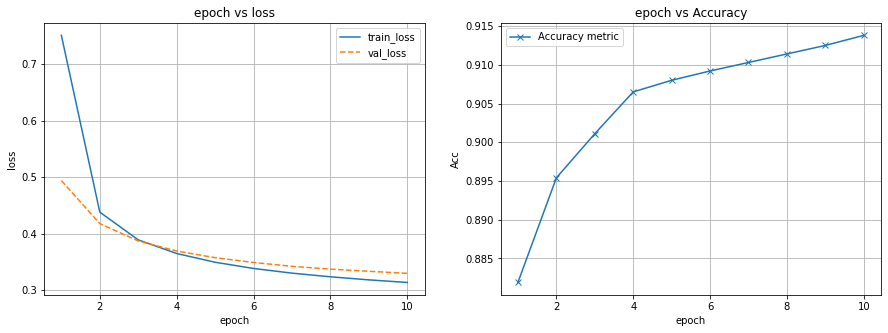

In [9]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(li_epoch, li_train_loss, label='train_loss')
ax1.plot(li_epoch, li_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(li_acc_epoch, li_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()